## SynDiffix Demo

This demo emulates how SynDiffix could be used if it were implemented in SQL. 

To emulate this, what we have done is pre-synthesized different combinations of columns and cached the results. In a real implementation, `SELECT col1, col2 FROM table` would cause only columns `col1` and `col2` to be synthesized. Likely the result would be cached, and subsequent operations on the same two columns would use the cached synthesized data. This demo essentially mimics queries to the cached syntheses.

### Tables

This demo looks at two datasets, the `census` dataset and the `taxi` dataset. We'll learn more about those datasets as we go.

In [1]:
import combsTables
import pandas as pd
import matplotlib.pyplot as plt
qh = combsTables.queryHandler(pgHost='db001.gda-score.org', pgUser='direct_user', pgPass='demo', dbName='sdx_demo')

### Comparing synthetic and original data

In this notebook, we frequently make comparisions between the original and synthetic data. In practice, for an untrusted user, this won't be possible. However, it will be possible to provide an indication as to the accuracy of the synthetic data, both in terms of coverage and numeric accuracy.

## Census

### SELECT * FROM census

The first thing a user is likely to do when encountering a new dataset is to inspect the first few rows of data. We do that here for the census data.

Note that with SynDiffix, the more columns you synthesize, the worse the accuracy per-column. Therefore, `SELECT *` is useful for an initial inspection of the data values, but should not be used for statistical analysis of specific parts of the data. (On the other hand, it should also be used for ML modeling use cases, but at the moment we are not emulating that.)

The following code (`qh.query(sql)`) is used to generate results for both the original and synthesized data. We do that here so that we can compare the two. Naturally in a real setting with an untrusted user, the original data would not be returned. `qh.query(sql)` also selects the appropriate cached synthetic dataset to use. It does this by inspecting the columns selected in the query, and selecting the synthetic table that has only those columns.

In [2]:
sql = "SELECT * FROM census_orig_ LIMIT 5"
dfOrigAll, dfSynAll = qh.query(sql)

Here are the first 5 rows of the original data:

In [3]:
dfOrigAll.head()

,index,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,label
0,0,34.0,Self-employed-incorporated,35.0,17.0,Some college but no degree,0.0,Not in universe,Separated,Finance insurance and real estate,...,Mexico,Mexico,Mexico,Foreign born- U S citizen by naturalization,0.0,Not in universe,2.0,52.0,95.0,50000+
1,1,13.0,Not in universe,0.0,0.0,Children,0.0,Not in universe,Never married,Not in universe or children,...,United-States,United-States,United-States,Native- Born in the United States,0.0,Not in universe,0.0,0.0,95.0,- 50000
2,2,18.0,Not in universe,0.0,0.0,12th grade no diploma,0.0,High school,Never married,Not in universe or children,...,United-States,United-States,United-States,Native- Born in the United States,0.0,Not in universe,2.0,8.0,95.0,- 50000
3,3,27.0,Private,42.0,13.0,Associates degree-occup /vocational,0.0,Not in universe,Never married,Medical except hospital,...,United-States,United-States,United-States,Native- Born in the United States,0.0,Not in universe,2.0,50.0,95.0,- 50000
4,4,6.0,Not in universe,0.0,0.0,Children,0.0,Not in universe,Never married,Not in universe or children,...,Philippines,Philippines,United-States,Native- Born in the United States,0.0,Not in universe,0.0,0.0,94.0,- 50000


And here they are for the synthesized data:

In [4]:
dfSynAll.head()

,index,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,label
0,0,45.0,Private,19.0,36.0,Bachelors degree(BA AB BS),0.0,Not in universe,Never married,Manufacturing-durable goods,...,United-States,United-States,United-States,Native- Born in the United States,0.0,Not in universe,2.0,18.0,95.0,- 50000
1,1,30.0,Private,16.0,35.0,11th grade,0.0,Not in universe,Never married,Manufacturing-durable goods,...,United-States,United-States,United-States,Native- Born in the United States,0.0,Not in universe,2.0,52.0,95.0,- 50000
2,2,21.0,Local government,43.0,10.0,High school graduate,0.0,College or university,Never married,Education,...,United-States,United-States,United-States,Native- Born in the United States,0.0,Not in universe,2.0,52.0,95.0,- 50000
3,3,20.0,Private,33.0,17.0,Some college but no degree,0.0,Not in universe,Never married,Retail trade,...,United-States,United-States,United-States,Native- Born in the United States,2.0,Not in universe,2.0,52.0,94.0,- 50000
4,4,21.0,Private,39.0,13.0,Some college but no degree,0.0,Not in universe,Never married,Business and repair services,...,United-States,United-States,United-States,Native- Born in the United States,0.0,Not in universe,2.0,13.0,94.0,- 50000


We an see from this that a user can "see" the data perfectly well from the anonymized data. (Note that for columns with many unique values, this won't be the case.)

### Basic statistics for continuous columns

Most of the `census` data is categorical, but a few columns have continuous data. Let's look at a variety of statistics for `age`.

In [5]:
sql = '''
SELECT count(age) as count,
       count(distinct age) as distinct,
       avg(age) as avg,
       stddev(age) as stdev,
       min(age) as min,
       max(age) as max
FROM census_orig_'''
dfOrig, dfSyn = qh.query(sql)

In [6]:
dfOrig.head()

,count,distinct,avg,stdev,min,max
0,209499,91,34.545592,22.329496,0.0,90.0


In [7]:
dfSyn.head()

,count,distinct,avg,stdev,min,max
0,209498,91,34.54602,22.329791,0.0,90.0


As can be seen from the above, the basic statistics for the original and synthesized data over the age column are extremely close. In this particular case, there are enough examples of every age that no ages were suppressed (the number of distinct ages are the same), and the min and max are also correct.

### Histogram of ages
Let's look at a histogram of ages, grouped by 10. We use a little math to specify the grouping.

In [8]:
sql = '''
SELECT (floor(age/10))*10 as age_by_10,
       count(*) as cnt
FROM census_orig_
GROUP BY 1
'''
dfOrig, dfSyn = qh.query(sql)

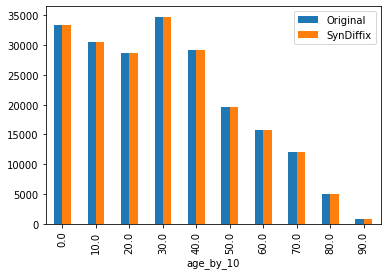

In [9]:
df = pd.merge(dfOrig, dfSyn, on='age_by_10')
df = df.rename(columns={'cnt_x': 'Original', 'cnt_y': 'SynDiffix'})
ax = df.plot(kind='bar', x='age_by_10')

Of course, when the counts are large, the error is very small (here imperceptable).

## Race and education

Let's see if we can tease out the rationship between race and education. Let's start by looking at the distribution of each column.

In [10]:
sql = '''
SELECT education, count(*) as cnt
FROM census_orig_
GROUP BY 1
'''
dfOrig, dfSyn = qh.query(sql)

Let's use the following histogram to make sure that the synthetic data has the same number of categories as the original data, and is accurate. (Note again that a real system would provide this accuracy feedback.)

<AxesSubplot:xlabel='education'>

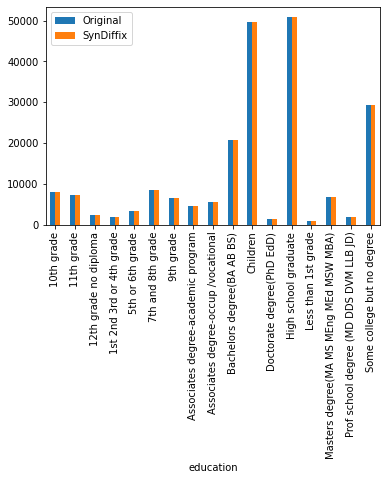

In [11]:
df = pd.merge(dfOrig, dfSyn, on='education')
df = df.rename(columns={'cnt_x': 'Original', 'cnt_y': 'SynDiffix'})
df.plot(kind='bar', x='education')

There is a matching SynDiffix bar for every Original bar, so our synthetic data is good. Therefore to keep things simple, we can work with only the synthetic data in what follows.

There are a lot of different education levels here, so let's use `CASE` to categorize them.

In [12]:
sql = '''
SELECT concat(race, ',', edu_level) AS race_edu, cnt
FROM    (SELECT race,
		CASE
			WHEN education IN (
			'Less than 1st grade',
			'1st 2nd 3rd or 4th grade',
			'5th or 6th grade'
			) THEN '0-6'
			WHEN education IN (
			'7th and 8th grade',
			'9th grade',
			'10th grade',
			'11th grade',
			'12th grade no diploma'
			) THEN '07-11'
			WHEN education IN (
			'High school graduate'
			) THEN '12'
			WHEN education IN (
			'Associates degree-academic program',
			'Associates degree-occup /vocational',
			'Bachelors degree(BA AB BS)',
			'Masters degree(MA MS MEng MEd MSW MBA)',
			'Prof school degree (MD DDS DVM LLB JD)',
			'Doctorate degree(PhD EdD)',
			'Some college but no degree'
			) THEN '12+'
			ELSE 'NA'
		END AS edu_level,
		count(*) AS cnt
	FROM (SELECT education,
			CASE
				WHEN race = 'Amer Indian Aleut or Eskimo' THEN 'Other'
				WHEN race = 'Asian or Pacific Islander' THEN 'Other'
				ELSE race
			END AS race
		FROM census_orig_ ) t1
	GROUP BY 1,2 ) t2
'''
dfOrig, dfSyn = qh.query(sql)

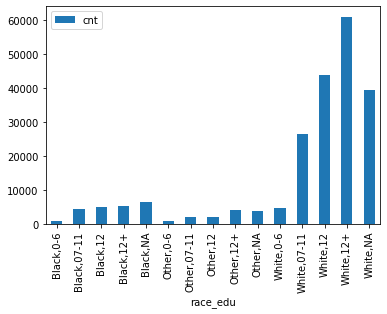

In [13]:
ax = dfSyn.plot(kind='bar', x='race_edu')

We see here that for Whites, there is a substantial increase with each higher education level, whereas for Blacks, in increase is far less.

Let's go ahead and compare original with synthetic and make sure everything is ok.

<AxesSubplot:xlabel='race_edu'>

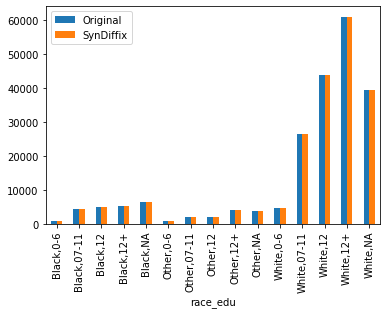

In [14]:
df = pd.merge(dfOrig, dfSyn, on='race_edu')
df = df.rename(columns={'cnt_x': 'Original', 'cnt_y': 'SynDiffix'})
df.plot(kind='bar', x='race_edu')

An important point from this example is that, using a synthetic data approach, any SQL can be used without limitation. 

## Taxi

The taxi data is event (time-series) data. The Protected Entity is the driver, and the column with the Protected Entity ID (PID) is `hack`. 

> (Note that due to some dirty entries in the original data, pandas failed to select the correct column types for a few columns. They are the two datetime columns and the two dropoff locations.)

### Suppression of unique values

In [15]:
sql = "SELECT * FROM taxi_orig_ LIMIT 5"
dfOrigAll, dfSynAll = qh.query(sql)

In [16]:
dfOrigAll.head()

,index,med,vendor_id,rate_code,sf_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,lastname
0,0,AF7386DF75DCB4EFFF15740F3F5A5722,CMT,1.0,N,2013-01-08T21:42:52.0000000,2013-01-08T21:57:38.0000000,1.0,885.0,4.00,...,-73.946915,40.77409,CRD,15.0,0.5,0.5,2.0,0.0,18.0,Simpson
1,1,E81395630B8AF74FE4CF3833E1C5F736,VTS,1.0,,2013-01-08T22:06:00.0000000,2013-01-08T22:12:00.0000000,1.0,360.0,1.27,...,-73.971992,40.749821,CSH,6.5,0.5,0.5,0.0,0.0,7.5,Dukes
2,2,B293D6A8A232BE1C6D6A3E094BC50B51,VTS,1.0,,2013-01-08T09:30:00.0000000,2013-01-08T09:38:00.0000000,6.0,480.0,1.36,...,-73.970901,40.798286,CSH,7.5,0.0,0.5,0.0,0.0,8.0,Blalock
3,3,15D87A6492BD49FBB319F4E657C33A16,CMT,1.0,N,2013-01-08T14:57:19.0000000,2013-01-08T15:04:42.0000000,1.0,443.0,0.60,...,-73.980331,40.756039,CRD,6.5,0.0,0.5,1.4,0.0,8.4,Bunch
4,4,D41814EBC98E4ED03F5F39F7579DA784,VTS,1.0,,2013-01-08T08:00:00.0000000,2013-01-08T08:06:00.0000000,1.0,360.0,1.19,...,-73.976974,40.760853,CRD,6.5,0.0,0.5,1.3,0.0,8.3,Walker


In [17]:
dfSynAll.head()

,index,med,vendor_id,rate_code,sf_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,lastname
0,0,F*12453,VTS,1.0,,2013-01-07T23:50:00.0000000,2013-01-07T23:52:41.5209008,5.0,62.0,0.44,...,-73.9451*10629,40.8*48312,CSH,3.5,0.0,0.5,0.0,0.0,4.5,Morgan
1,1,E0*11379,CMT,1.0,N,2013-01-07T23:50:00.0000000,2013-01-08T00:00:00.0000000,1.0,300.0,0.55,...,-73.966087,40.8*47565,CSH,4.5,0.0,0.5,0.0,0.0,5.5,Kr*5975
2,2,E0*11379,CMT,2.0,N,2013-01-07T23:51:00.0000000,2013-01-07T23:54:09.0151600,1.0,300.0,0.55,...,-73.938103,40.8047*47565,CSH,4.5,0.0,0.5,0.0,0.0,5.5,Kr*5975
3,3,163*1152,CMT,1.0,N,2013-01-07T23:49:48.5231880,2013-01-08T00:03:00.0000000,1.0,1620.0,5.80,...,-73.961365,40.71443*12443,CSH,21.5,0.0,0.5,0.0,0.0,26.4,To*11050
4,4,163*1152,CMT,1.0,N,2013-01-08T00:02:00.0000000,2013-01-08T00:01:00.0000000,1.0,1620.0,5.80,...,-74.009865,40.7144*12445,CSH,21.5,0.0,0.5,0.0,0.0,26.4,To*11050


The `taxi` data has two columns that contain many unique text values (besides the four incorrectly typed columns). They are `med` and `lastname`. `med` is the taxi number, and for this dataset most drivers used only one taxi. As can be seen, when a value must be suppressed, SynDiffix as currently implemented displays as much of the string prefix as possible followed by `*` and a number. This can be improved to produce a syntactically correct string, but we haven't done that work yet.

Looking at `lastname`, the reason that 'Morgan' is displayed properly is because there are multiple drivers with that name, and so it does not need to be suppressed.

### Basic statistics for fare_amount

Let's look at the basic statistics for `fare_amount`.

In [18]:
sql = '''
SELECT count(fare_amount) as count,
       count(distinct fare_amount) as distinct,
       avg(fare_amount) as avg,
       stddev(fare_amount) as stdev,
       min(fare_amount) as min,
       max(fare_amount) as max
FROM taxi_orig_'''
dfOrig, dfSyn = qh.query(sql)

In [19]:
dfOrig.head()

,count,distinct,avg,stdev,min,max
0,308179,294,11.503308,9.440779,2.5,300.0


In [20]:
dfSyn.head()

,count,distinct,avg,stdev,min,max
0,308186,264,11.504305,9.43207,2.5,255.354771


While the average and standard deviation are very accurate, the max is off by a substantial amount (255 instead of 300). This is because SynDiffix reduces the values of outliers so as to more closely match other values (i.e. to "hide" the outliers among other values).

### Flattening of outlier values

Let's look at the highest `fare_amount` values more closely.

In [21]:
sql = '''
SELECT fare_amount
FROM taxi_orig_
ORDER BY fare_amount DESC
LIMIT 50000
'''
dfOrig, dfSyn = qh.query(sql)

In [22]:
dfOrig.head(8)

,fare_amount
0,300.0
1,285.0
2,285.0
3,249.5
4,248.0
5,240.0
6,232.5
7,225.0


In [23]:
dfSyn.head(8)

,fare_amount
0,255.354771
1,252.393973
2,251.847243
3,250.585804
4,250.011757
5,245.230144
6,232.853112
7,227.322681


Above we can see that the values of the top three `fare_amount`'s were reduced ("flattened") to values close to the next few. 

<AxesSubplot:>

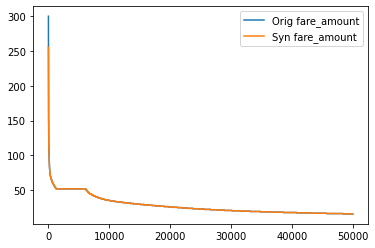

In [24]:
df = pd.concat([dfOrig['fare_amount'], dfSyn['fare_amount']], axis=1, keys=['Orig fare_amount', 'Syn fare_amount'])
df.plot(y=['Orig fare_amount','Syn fare_amount'])

Here we see that the ordered `fare_amount` for original and synthetic data track very closely, with the exception of the original outliers.

### Column pair statistics

Let's look at a few statistics regarding how `fare_amount` and `trip_distance` relate to each other. We expect these two columns to have a strong correlation.

In [25]:
sql = ''' 
SELECT corr(fare_amount, trip_distance) as correlation,
       covar_pop(fare_amount, trip_distance) as covariance,
       regr_intercept(fare_amount, trip_distance) as intercept
FROM taxi_orig_
'''
dfOrig, dfSyn = qh.query(sql)

In [26]:
dfOrig.head()

,correlation,covariance,intercept
0,0.885897,27.202688,4.522786


In [27]:
dfSyn.head()

,correlation,covariance,intercept
0,0.887138,26.876243,4.52374


The main point to observe here is that these pairwise statistics for the synthetic data are quite accurate. Both correlation and the y-intercept of the least squares fit are well within 1%. The covariance is off by about 1.2%. 

As expected, the correlation is high.